torch.Size([1, 100, 784])
torch.Size([1, 100, 784])


/Users/samgriesemer/miniconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTMCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


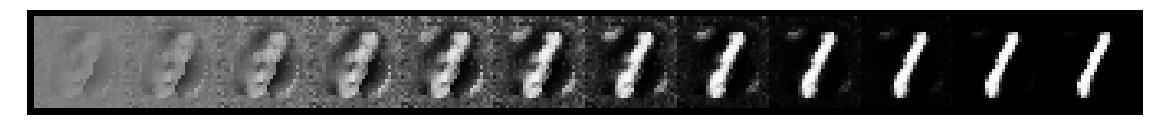

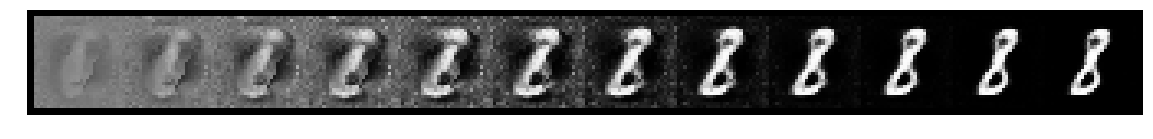

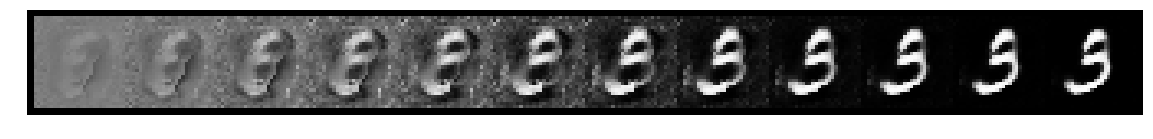

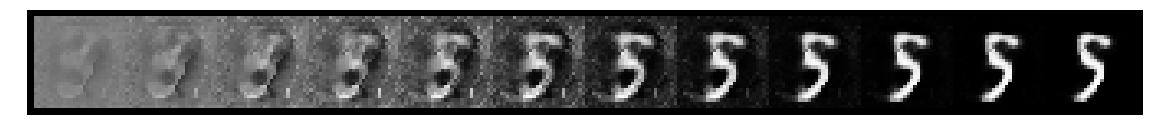

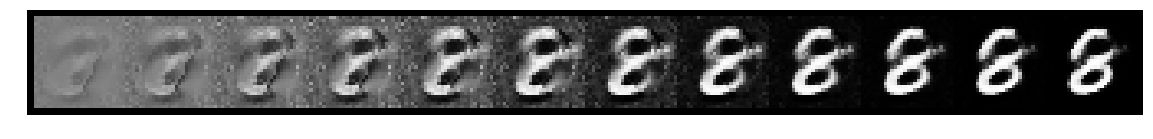

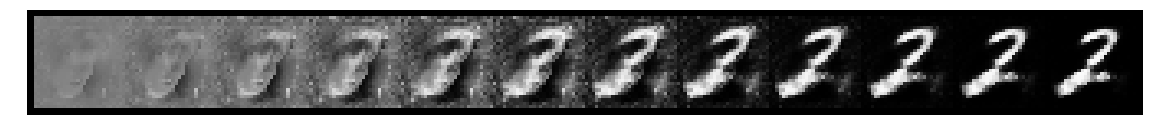

In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class AME(nn.Module):
    def __init__(self, ninp1, nhid1, ninp2, nhid2):
        super(AME, self).__init__()

        self.lstm1 = nn.LSTMCell(ninp1, nhid1)
        self.lstm21 = nn.LSTMCell(ninp2, nhid2)
        self.lstm22 = nn.LSTMCell(ninp2, nhid2)
        
        #self.ninp = ninp1
        #self.nhid = nhid

    def forward(self, input, h_00, h_10, enc=False):
        h_01, c_01 = self.lstm1(input, h_00)
        h_11, c_11 = self.lstm21(h_01, h_10)
        if enc: 
            h_enc, c_enc = self.lstm22(h_01, enc)
            return h_11, h_enc, (h_01, c_01), (h_11, c_11), (h_enc, c_enc)

        #canvas_1 = h_11.add(canvas_0)

        return h_11, (h_01, c_01), (h_11, c_11)

class VAE(nn.Module):
    def __init__(self, ninp):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(ninp, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, ninp)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def vloss(self, recon_x, x, mu, logvar):
        BCE = reconstruction_function(recon_x, x)

        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)

        return BCE + KLD

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

lr = 1.0
bsz = 100
clip = 0.5
log_interval = 10
criterion = nn.BCELoss()
sample_iters = 6
ame_list = []
vae_list = []
loss_list = []
epochs = 2

# get data
transform=transforms.Compose([transforms.ToTensor()
                             ])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bsz, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bsz, 
                                          shuffle=False, num_workers=2)

data_list = []
for i, data in enumerate(trainloader):
    inputs, labels = data
    inputs = torch.round(inputs)
    data_list.append(inputs.view(1,bsz,784))
print(data_list[0].size())
data_list = torch.cat(data_list)

test_list = []
for i, data in enumerate(testloader):
    inputs, labels = data
    inputs = torch.round(inputs)
    test_list.append(inputs.view(1,bsz,784))
print(test_list[0].size())
test_list = torch.cat(test_list)

ninp = data_list.size(-1)
mid_size = 400
latent_size = 100

with open('avme.pt', 'rb') as f:
    ame_dec_v = torch.load(f)
    
with open('avme_enc.pt', 'rb') as f:
    ame_enc_v = torch.load(f)

## showing images ##

def imshow(img):
    #img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    
canvas_list_1 = []
canvas_list_2 = []
canvas_list_3 = []
canvas_list_4 = []
canvas_list_5 = []
canvas_list_6 = []

canvas = Variable(torch.zeros(bsz,784))
output = Variable(torch.zeros(bsz,784))

h_dec_1 = (Variable(torch.zeros(bsz,mid_size)), Variable(torch.zeros(bsz,mid_size)))
h_dec_2 = (Variable(torch.zeros(bsz,ninp)), Variable(torch.zeros(bsz,ninp)))


for i in range(12):
    sample = Variable(torch.randn(bsz,latent_size))
    output, h_dec_1, h_dec_2 = ame_dec_v(sample, h_dec_1, h_dec_2)
    canvas = canvas.add(output)
    canvas_list_1.append(canvas.sigmoid().view(bsz,1,28,28).data[:1])
    canvas_list_2.append(canvas.sigmoid().view(bsz,1,28,28).data[1:2])
    canvas_list_3.append(canvas.sigmoid().view(bsz,1,28,28).data[2:3])
    canvas_list_4.append(canvas.sigmoid().view(bsz,1,28,28).data[3:4])
    canvas_list_5.append(canvas.sigmoid().view(bsz,1,28,28).data[4:5])
    canvas_list_6.append(canvas.sigmoid().view(bsz,1,28,28).data[5:6])


#torch.cat(canvas_list,3).view(2,1,1,28,336).size()
#pic = canvas_list[11].view(1,28,28)
pic = torch.cat(canvas_list_1,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))
pic = torch.cat(canvas_list_2,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))
pic = torch.cat(canvas_list_3,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))
pic = torch.cat(canvas_list_4,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))
pic = torch.cat(canvas_list_5,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))
pic = torch.cat(canvas_list_6,3)
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(pic))